In [1]:
import tensorflow as tf
from functools import partial
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift
from alibi_detect.cd import KSDrift
import numpy as np
import methods
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from ood_metrics import calc_metrics, plot_roc, plot_pr, plot_barcode

import logging 
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# Assume that you have 12GB of GPU memory and want to allocate ~4GB:
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.1)

sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

Num GPUs Available:  1


In [2]:
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
import torch
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [3]:
from collections import OrderedDict

import numpy as np
import torch as th
from torch import nn
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import cv2 

import math
from scipy.spatial import distance as mahal_distance

from skimage.util import random_noise
classes = np.array(['uCry', 'sCry', 'cCry', 'hCast', 'nhCast', 'sEC', 'nsEC', 'WBC', 'RBC'])
outlier_classes1 = np.array(['Artifact', 'Dirt', 'LD'])
outlier_classes2 = np.array(['blankurine', 'bubbles', 'cathair', 'condensation', 'dust', 'feces', 'fingerprint', 'humanhair',
                            'Lipids', 'Lotion', 'pollen', 'semifilled', 'void', 'wetslide', 'yeast'])
# Loading the pre-trained classifier

def conv_bn_relu(
        in_channels, out_channels,
        kernel_size=3, padding=None, stride=1,
        depthwise=False, normalization=True,
        activation=True, init_bn_zero=False):
    """
    Make a depthwise or normal convolution layer, 
    followed by batch normalization and an activation.
    """
    layers = []
    padding = kernel_size // 2 if padding is None else padding

    if depthwise and in_channels > 1:
        layers += [
            nn.Conv2d(in_channels, in_channels, bias=False,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding, groups=in_channels),
            nn.Conv2d(in_channels, out_channels, 
                      bias=not normalization, kernel_size=1)
        ]
    else:
        layers.append(
            nn.Conv2d(in_channels, out_channels, bias=not normalization,
                      kernel_size=kernel_size, stride=stride,
                      padding=padding)
        )
    if normalization:
        bn = nn.BatchNorm2d(out_channels)
        if init_bn_zero:
            nn.init.zeros_(bn.weight)
        layers.append(bn)
    if activation:
        # TODO: parametrize activation
        layers.append(nn.ReLU())
    return nn.Sequential(*layers)

def depthwise_cnn_classifier(
    channels=[],
    strides=None,
    img_width=32,
    img_height=32,
    c_in=None,
    c_out=None,
):
    channels = channels[:]
    if c_in is not None:
        channels.insert(0, c_in)
    if c_out is not None:
        channels.append(c_out)

    if len(channels) < 2:
        raise ValueError("Not enough channels")

    layers = OrderedDict()
    number_convolutions = len(channels) - 2

    if strides is None:
        strides = [2] * number_convolutions

    out_width = img_width
    out_height = img_height

    for layer_index in range(number_convolutions):
        in_channels = channels[layer_index]
        out_channels = channels[layer_index + 1]
        layers["conv1" + str(layer_index)] = conv_bn_relu(
            in_channels,
            out_channels,
            kernel_size=3,
            stride=strides[layer_index],
            depthwise=layer_index > 0,
            normalization=True,
            activation=True,
        )
        layers["conv2" + str(layer_index)] = conv_bn_relu(
            out_channels,
            out_channels,
            kernel_size=3,
            stride=1,
            depthwise=True,
            normalization=True,
            activation=True,
        )

        out_width = out_width // strides[layer_index]
        out_height = out_height // strides[layer_index]

    layers["drop"] = nn.Dropout(p=0.2)
    layers["flatten"] = nn.Flatten()
    layers["final"] = nn.Linear(out_width * out_height * channels[-2], channels[-1])
    #layers["softmax"] = nn.Softmax(-1)

    return nn.Sequential(layers)



# load model
cnn = depthwise_cnn_classifier([32, 64, 128], c_in=1, c_out=9, img_width=32, img_height=32)
cnn.load_state_dict(th.load("/home/erdem/pickle/thomas_classifier/urine_classifier_uniform_32x32.pt"))
cnn.eval()  # IMPORTANT
cnn

Sequential(
  (conv10): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv20): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv11): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=32, bias=False)
    (1): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
  )
  (conv21): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=64, bias=False)
    (1): Conv2d(64, 64, kernel_size=(1, 1),

In [4]:
from copy import deepcopy
cnn_flattened = deepcopy(cnn)
del cnn_flattened[-1] # remove linear

In [5]:
inlier_names = ["cCry", "sCry", "uCry", "hCast", "nhCast", "nsEC", "sEC", "WBC", "RBC", "Artifact", "Dirt", "LD"]
testImages_cCry = methods.getTestRawImages("cCry", (32,32))
testImages_sCry = methods.getTestRawImages("sCry", (32,32))
testImages_uCry = methods.getTestRawImages("uCry", (32,32))
testImages_hCast = methods.getTestRawImages("hCast", (32,32))
testImages_nhCast = methods.getTestRawImages("nhCast", (32,32))
testImages_nsEC = methods.getTestRawImages("nsEC", (32,32))
testImages_sEC = methods.getTestRawImages("sEC", (32,32))
testImages_WBC = methods.getTestRawImages("WBC", (32,32))
testImages_RBC = methods.getTestRawImages("RBC", (32,32))
testImages_Artifact = methods.getTestRawImages("Artifact", (32,32))
testImages_Dirt = methods.getTestRawImages("Dirt", (32,32))
testImages_LD = methods.getTestRawImages("LD", (32,32))

X_inliers = np.concatenate((testImages_cCry, testImages_sCry, testImages_uCry, testImages_hCast, testImages_nhCast, testImages_nsEC,
                       testImages_sEC, testImages_WBC, testImages_RBC))
unclassified_imgs = methods.getTestRawImages("Unclassified", (32,32))

In [6]:
def getPermuteOutputs(f, X):
    outputs = []
    for x in X:
        outputs.append(f(th.from_numpy(x.reshape(1,1,32,32)) - 1).detach().view(-1).numpy())   
    return np.asarray(outputs).reshape(-1, 2048)

In [23]:
def test_ksd(cd, imgs_ref, imgs, outlier_imgs, label):
    p_vals = []
    distances = []
    labels = []
    imgs_array = []
    for img in imgs:
        p_val, dist = cd.feature_score(x_ref=imgs_ref, x=img.reshape(-1,9))
        p_vals.append(np.mean(p_val))
        distances.append(np.mean(dist))
        labels.append(label)
    d = {"p_vals": p_vals, "distances": distances, "labels": labels, "imgs_array": outlier_imgs.tolist()}

    df = pd.DataFrame(data=d)
    return df
def test_ksd_final(cd, f, imgs_ref, perturb = None, y_limit = None):
    inlier_scores = []
    inlier_labels = []
    outlier_scores = []
    outlier_labels = []
    inlier_path = "/home/erdem/dataset/urine_test_32/inliers"
    outlier_path = "/home/erdem/dataset/urine_test_32/outliers"
    # Inliers
    for img_path in Path(inlier_path).glob("*.png"):
        inlier_labels.append(0)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        output = f(th.from_numpy(image.reshape(1,1,32,32)) - 1).detach().view(-1).numpy()
        _, dist = cd.feature_score(x_ref=imgs_ref, x=output.reshape(1, 2048))
        temp_score = np.amax(np.mean(dist))
        inlier_scores.append(temp_score)
    
    # Outliers
    for img_path in Path(outlier_path).glob("*.png"):
        outlier_labels.append(1)
        image = plt.imread(img_path)
        if perturb == 'gaussian':
            image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
        elif perturb == 's&p':
            image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, amount=0.03, clip=True))
        output = f(th.from_numpy(image.reshape(1,1,32,32)) - 1).detach().view(-1).numpy()
        _, dist = cd.feature_score(x_ref=imgs_ref, x=output.reshape(1, 2048))
        temp_score = np.amax(np.mean(dist))
        outlier_scores.append(temp_score)
    
    d_outliers = {"K-S Distance": outlier_scores, "outlier_labels": outlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    d_inliers = {"K-S Distance": inlier_scores, "inlier_labels": inlier_labels, "Index of Image Patches": np.linspace(1, 636, num=636)}
    df1 = pd.DataFrame(data=d_inliers)
    df2 = pd.DataFrame(data=d_outliers)
    g = sns.scatterplot(data=df1, x="Index of Image Patches", y="K-S Distance")
    g = sns.scatterplot(data=df2, x="Index of Image Patches", y="K-S Distance")
    g.set(ylim=(0, y_limit))
    score_array = inlier_scores+outlier_scores
    label_array = inlier_labels+outlier_labels

    print(calc_metrics(score_array, label_array))

    plot_roc(score_array, label_array)
    plot_pr(score_array, label_array)
#     plot_barcode(score_array, label_array)

In [9]:
inlier_outputs = getPermuteOutputs(cnn_flattened, X_inliers)

In [10]:
inlier_outputs.shape

(7965, 2048)

In [11]:
unclassified_outputs = getPermuteOutputs(cnn_flattened, unclassified_imgs)

In [12]:
unclassified_outputs.shape

(1975, 2048)

In [1]:
cd = KSDrift(inlier_outputs, p_val=.05, correction = 'fdr', preprocess_x_ref=False)

NameError: name 'MMDDrift' is not defined

{'fpr_at_95_tpr': 0.7531446540880503, 'detection_error': 0.39937106918238996, 'auroc': 0.7234224813100748, 'aupr_out': 0.7209666817587475, 'aupr_in': 0.7351175244628316}


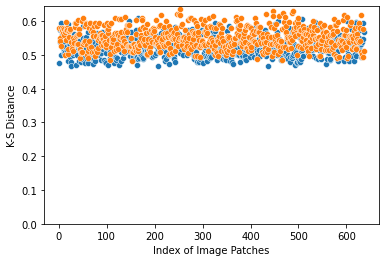

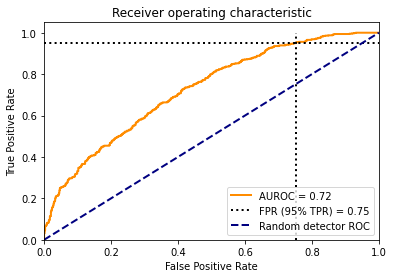

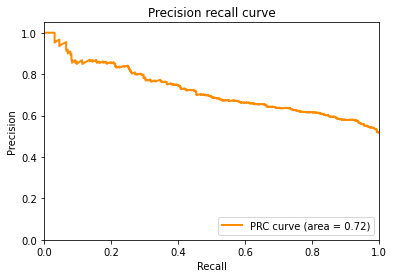

In [24]:
test_ksd_final(cd, cnn_flattened, inlier_outputs, perturb = None, y_limit = None)

<AxesSubplot:xlabel='outlier_labels', ylabel='outlier_scores'>

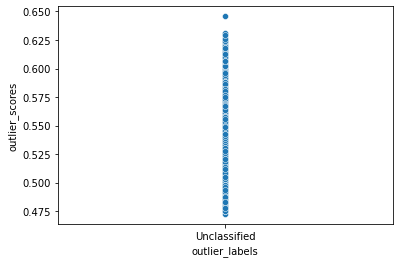

In [26]:
cl_path = "/home/thomas/tmp/patches_urine_32_scaled/Unclassified"
perturb = None
outlier_labels = []
outlier_scores = []
outlier_path = []
cl = "Unclassified"  
for img_path in Path(cl_path).glob("*.png"):
    outlier_path.append(img_path)
    outlier_labels.append(cl)
    image = plt.imread(img_path)
    if perturb == 'gaussian':
        image = th.tensor(random_noise(image, mode='gaussian', mean=0, var=0.01, clip=True)).float()
    elif perturb == 's&p':
        image = th.tensor(random_noise(image, mode='s&p', salt_vs_pepper=0.5, clip=True))
    output = cnn_flattened(th.from_numpy(image.reshape(1,1,32,32)) - 1).detach().view(-1).numpy()
    _, dist = cd.feature_score(x_ref=inlier_outputs, x=output.reshape(1, 2048))
    temp_score = np.amax(np.mean(dist))
    outlier_scores.append(temp_score)
    
d = {"outlier_scores": outlier_scores, "outlier_labels": outlier_labels, "outlier_path": outlier_path}

df3 = pd.DataFrame(data=d)
sns.scatterplot(data=df3, x = "outlier_labels", y="outlier_scores")

In [27]:
sorted_unclassified = df3.sort_values(by=['outlier_scores'])
from torchvision.utils import make_grid
from torchvision.io import read_image
import torchvision.transforms.functional as F
%matplotlib inline
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
unclassified_imgs = []
for path in sorted_unclassified["outlier_path"]:
    unclassified_imgs.append(read_image(str(path)))

In [71]:
cd.n_features

9

In [74]:
df_unclassified = test_ksd(cd, inlier_outputs, unclassified_outputs, unclassified_imgs, 0)

In [75]:
sorted_p_vals = df_unclassified.sort_values(by=['p_vals'])

<AxesSubplot:xlabel='labels', ylabel='p_vals'>

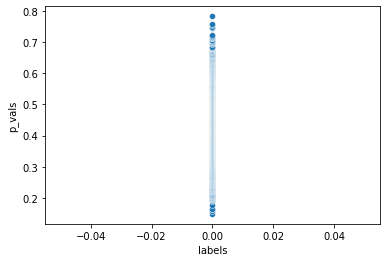

In [83]:
sns.scatterplot(data=sorted_p_vals, x = "labels", y="p_vals")